In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import optuna
import time
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Data Loading

In [2]:
df_train = pd.read_csv('..\\Dataset\\raw\\train.csv')
df_test = pd.read_csv('..\\Dataset\\raw\\test.csv')

In [3]:
# separate the label/class
label = df_train.pop('failure')

In [4]:
df_train.head(10)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885
5,5,A,75.35,material_7,material_8,9,5,11,4,0,...,20.810,10.622,14.904,19.107,13.327,15.354,19.251,NaN,17.625,832.902
6,6,A,161.71,material_7,material_8,9,5,12,2,4,...,17.916,11.370,17.714,19.924,11.560,16.653,17.734,NaN,16.637,684.438
7,7,A,177.92,material_7,material_8,9,5,4,8,8,...,18.643,10.254,16.449,20.478,12.207,15.624,16.968,15.176,17.231,684.000
8,8,A,109.50,material_7,material_8,9,5,9,6,5,...,19.887,11.557,15.965,19.604,14.091,15.674,13.327,13.535,15.408,NaN
9,9,A,98.72,material_7,material_8,9,5,10,4,7,...,19.011,10.384,15.237,18.427,12.635,14.318,14.327,12.867,NaN,NaN


In [5]:
df_train.shape

(26570, 25)

In [6]:
num_cols = ['loading', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']
cat_cols = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']

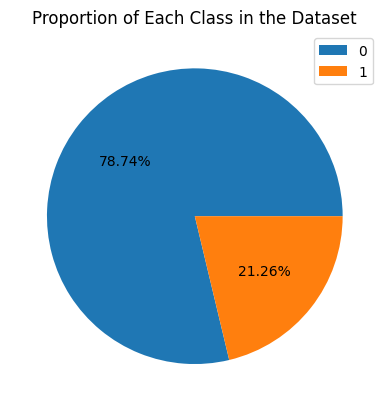

In [7]:
# Count frequency each class
category_counts = label.value_counts()
size = label.value_counts()

# Create Bar Chart
plt.pie(size, autopct="%.2f%%")
plt.legend(labels=category_counts.index)
plt.title('Proportion of Each Class in the Dataset')
plt.show()

# Preprocessing

In [8]:
def prepo(df):
    df_processed = df.copy()
    
    # Drop the "material_" word
    df_processed['attribute_0'] = df_processed['attribute_0'].str.replace('material_', '').astype(int)
    df_processed['attribute_1'] = df_processed['attribute_1'].str.replace('material_', '').astype(int)

    # Dropping the Non-informative Feature
    df_processed = df_processed.drop(columns=['id', 'product_code'])

    # Define Pipeline & Column Transformer
    num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # best method so far on this dataset
    ('scaler', StandardScaler()) # for speed up the runtime
    ])

    column_transformer = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, num_cols),
            ('cat', SimpleImputer(strategy='mean'), cat_cols)
        ]
    )

    # Fit and transform data
    df_processed = column_transformer.fit_transform(df_processed)

    # split data into feature & target
    X = df_processed
    y = label

    # split data into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # change the scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # change to array
    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

    return X_train, X_test, y_train, y_test


In [9]:
X_train, X_test, y_train, y_test = prepo(df_train)

In [10]:
# Determine the input and output dimensions
X_dim = X_train.shape[1]
y_dim = label.nunique()

# Modelling

In [11]:
# Dataframe for evaluation result each model
eval_columns = ['Model', 'Accuracy', 'F1', 'ROC AUC']
eval_results = pd.DataFrame(columns=eval_columns)
eval_results

,Model,Accuracy,F1,ROC AUC


## Deep Learning

### NODE : Neural Oblivious Decision Ensembles

In [12]:
class DeepObliviousDecisionTreeLayer(nn.Module):
    def __init__(self, input_dim, num_trees, tree_depth, hidden_dim):
        super(DeepObliviousDecisionTreeLayer, self).__init__()
        self.num_trees = num_trees
        self.tree_depth = tree_depth
        self.hidden_dim = hidden_dim
        
        # Define a deeper architecture with hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(tree_depth):
            self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim 
        
        self.output_layer = nn.Linear(hidden_dim, num_trees)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x)) 
        
        # Apply the output layer
        out = torch.sigmoid(self.output_layer(x))
        return out

class NODE(nn.Module):
    def __init__(self, input_dim, output_dim, num_trees, tree_depth, hidden_dim):
        super(NODE, self).__init__()
        self.tree_layer = DeepObliviousDecisionTreeLayer(input_dim, num_trees=num_trees, tree_depth=tree_depth, hidden_dim=hidden_dim)
        
        # Additional fully connected layers to make it deeper
        self.fc1 = nn.Linear(num_trees, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.tree_layer(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, num_epochs=100, learning_rate=0.001, batch_size=256):
    # Create data loaders for batch processing
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    def eval_model(model, data_loader):
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for batch_x, batch_y in data_loader:
                outputs = model(batch_x)
                y_prob = F.softmax(outputs, dim=1)
                y_true.append(batch_y)
                y_pred.append(y_prob)
        
        y_true = torch.cat(y_true).numpy()
        y_pred = torch.cat(y_pred).numpy()

        # Convert probabilities to class predictions
        y_pred_classes = torch.argmax(torch.from_numpy(y_pred), dim=1).numpy()

        # Compute accuracy and F1 score
        accuracy = accuracy_score(y_true, y_pred_classes)
        f1 = f1_score(y_true, y_pred_classes, average='weighted')

        # Compute AUC-ROC score for test data (binary classification)
        if y_pred.shape[1] == 2:
            y_prob_positive = y_pred[:, 1]
            auc_roc = roc_auc_score(y_true, y_prob_positive)
        else:
            auc_roc = 'N/A'

        return accuracy, f1, auc_roc

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        batch_auc_roc_scores = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate AUC-ROC for the current batch (only for binary classification)
            if outputs.size(1) == 2:
                y_prob_batch = F.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
                
                # Check if there is more than one class in the batch
                if len(np.unique(batch_y.cpu().numpy())) > 1:
                    auc_roc_batch = roc_auc_score(batch_y.cpu().numpy(), y_prob_batch)
                    batch_auc_roc_scores.append(auc_roc_batch)
                else:
                    print('AUC-ROC calculation skipped for batch with only one class')
        
        # Calculate average AUC-ROC for the epoch
        avg_batch_auc_roc = sum(batch_auc_roc_scores) / len(batch_auc_roc_scores) if batch_auc_roc_scores else 'N/A'
        
        # Print information every 10 epochs
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Avg Batch AUC-ROC: {avg_batch_auc_roc:.4f}' if avg_batch_auc_roc != 'N/A' else f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Final evaluation at the end of training
    print('Final Evaluation:')
    final_train_accuracy, final_train_f1, final_train_auc_roc = eval_model(model, train_loader)
    final_test_accuracy, final_test_f1, final_test_auc_roc = eval_model(model, test_loader)

    print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
    print(f'Final Train F1 Score: {final_train_f1:.4f}')
    print(f'Final Train AUC-ROC Score: {final_train_auc_roc:.4f}' if final_train_auc_roc != 'N/A' else 'Final Train AUC-ROC Score: N/A')
    print(f'Final Test Accuracy: {final_test_accuracy:.4f}')
    print(f'Final Test F1 Score: {final_test_f1:.4f}')
    print(f'Final Test AUC-ROC Score: {final_test_auc_roc:.4f}' if final_test_auc_roc != 'N/A' else 'Final Test AUC-ROC Score: N/A')
    
    return final_test_accuracy, final_test_f1, final_test_auc_roc

In [14]:
input_dim = X_dim
output_dim = y_dim
NODE_model = NODE(input_dim, output_dim, num_trees=10, tree_depth=6, hidden_dim=128)

In [15]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [16]:
result = train_and_evaluate_model(NODE_model, "NODE Classifier", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

C:\Users\fadhil\AppData\Local\Temp\ipykernel_10420\3282095067.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
C:\Users\fadhil\AppData\Local\Temp\ipykernel_10420\3282095067.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


Epoch [10/100], Loss: 0.5866
Epoch [20/100], Loss: 0.5172
Epoch [30/100], Loss: 0.5196
Epoch [40/100], Loss: 0.5175
Epoch [50/100], Loss: 0.5175
Epoch [60/100], Loss: 0.5174
Epoch [70/100], Loss: 0.5172
Epoch [80/100], Loss: 0.5170
Epoch [90/100], Loss: 0.5158
Epoch [100/100], Loss: 0.5077
Final Evaluation:
Final Train Accuracy: 0.7874
Final Train F1 Score: 0.6937
Final Test Accuracy: 0.7874
Final Test F1 Score: 0.6937


C:\Users\fadhil\AppData\Local\Temp\ipykernel_10420\1212388360.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_results = pd.concat([result, eval_results], ignore_index=True)


### Tab-Transformer

In [17]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion),
            nn.ReLU(),
            nn.Linear(forward_expansion, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is expected to have shape [batch_size, sequence_length, embed_size]
        attention = self.attention(x, x, x)[0]
        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, embed_size, num_heads, forward_expansion, dropout):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_size)
        self.transformer_block = TransformerBlock(
            embed_size=embed_size,
            heads=num_heads,
            dropout=dropout,
            forward_expansion=forward_expansion
        )
        self.fc = nn.Linear(embed_size, output_dim)

    def forward(self, x):
        # Add sequence dimension
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.transformer_block(x)
        x = x.squeeze(1)
        out = self.fc(x)
        return out

In [18]:
# Define Tab-Transfomer Model
TabTR_model = TabularTransformer(
    input_dim=input_dim,
    output_dim=output_dim,
    embed_size=32,
    num_heads=4,
    forward_expansion=128,
    dropout=0.1
)

: 

In [19]:
result = train_and_evaluate_model(TabTR_model, "Tab-Transformer", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

C:\Users\fadhil\AppData\Local\Temp\ipykernel_10420\3282095067.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
C:\Users\fadhil\AppData\Local\Temp\ipykernel_10420\3282095067.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


### TabNet

In [ ]:
# Define TabNet Model
TabNet_model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         scheduler_params=dict(step_size=10, gamma=0.9),
                         mask_type='sparsemax')

# Train TabNet_model
TabNet_model.fit(X_train=X_train, 
          y_train=y_train, 
          eval_set=[(X_test, y_test)],
          eval_metric=['accuracy', 'auc'],
          max_epochs=100, 
          patience=10,
          batch_size=256,
          virtual_batch_size=128,
          num_workers=0,
          drop_last=False)

result = train_eval_non_scratch(TabNet_model, "Tabnet", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55543 | val_0_accuracy: 0.78735 | val_0_auc: 0.52068 |  0:00:02s
epoch 1  | loss: 0.51661 | val_0_accuracy: 0.78754 | val_0_auc: 0.561   |  0:00:05s
epoch 2  | loss: 0.51512 | val_0_accuracy: 0.78735 | val_0_auc: 0.56659 |  0:00:08s
epoch 3  | loss: 0.51601 | val_0_accuracy: 0.78735 | val_0_auc: 0.56472 |  0:00:11s
epoch 4  | loss: 0.5135  | val_0_accuracy: 0.78735 | val_0_auc: 0.57902 |  0:00:13s
epoch 5  | loss: 0.51189 | val_0_accuracy: 0.78735 | val_0_auc: 0.57787 |  0:00:16s
epoch 6  | loss: 0.51256 | val_0_accuracy: 0.78735 | val_0_auc: 0.57577 |  0:00:19s
epoch 7  | loss: 0.51156 | val_0_accuracy: 0.78735 | val_0_auc: 0.58253 |  0:00:22s
epoch 8  | loss: 0.51163 | val_0_accuracy: 0.78735 | val_0_auc: 0.57931 |  0:00:24s
epoch 9  | loss: 0.51149 | val_0_accuracy: 0.78735 | val_0_auc: 0.57449 |  0:00:27s
epoch 10 | loss: 0.51226 | val_0_accuracy: 0.78735 | val_0_auc: 0.572   |  0:00:30s
epoch 11 | loss: 0.51173 | val_0_accuracy: 0.78735 | val_0_auc: 0.57378 |  0

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.7874
F1: 0.6937
roc_auc: 0.5825


## Machine Learning

### Random Forest

In [ ]:
# Define Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(rf_model, "Random Forest", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.7872
F1: 0.6939
roc_auc: 0.5415


### XGBoost

In [ ]:
# Define XGBoost Model
xgb_model = XGBClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(xgb_model, "XGBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.7717
F1: 0.7005
roc_auc: 0.5366


### LightGBM

In [ ]:
# Define LightGBM Model
lgbm_model = LGBMClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(lgbm_model, "LightGBM", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

[LightGBM] [Info] Number of positive: 4519, number of negative: 16737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4180
[LightGBM] [Info] Number of data points in the train set: 21256, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212599 -> initscore=-1.309331
[LightGBM] [Info] Start training from score -1.309331
Accuracy: 0.7862
F1: 0.6945
roc_auc: 0.5503


### CatBoost

In [ ]:
# Define CatBoost Model
cb_model = CatBoostClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(cb_model, "CatBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Learning rate set to 0.037999
0:	learn: 0.6783259	total: 9.46ms	remaining: 9.45s
1:	learn: 0.6653569	total: 17.8ms	remaining: 8.89s
2:	learn: 0.6534001	total: 26.2ms	remaining: 8.7s
3:	learn: 0.6418791	total: 33.8ms	remaining: 8.41s
4:	learn: 0.6317432	total: 41.5ms	remaining: 8.26s
5:	learn: 0.6224813	total: 48.5ms	remaining: 8.04s
6:	learn: 0.6133877	total: 56ms	remaining: 7.95s
7:	learn: 0.6051032	total: 64.3ms	remaining: 7.98s
8:	learn: 0.5974258	total: 70.8ms	remaining: 7.8s
9:	learn: 0.5903609	total: 78ms	remaining: 7.72s
10:	learn: 0.5838927	total: 84.8ms	remaining: 7.63s
11:	learn: 0.5780067	total: 92ms	remaining: 7.57s
12:	learn: 0.5726147	total: 99.3ms	remaining: 7.54s
13:	learn: 0.5674656	total: 106ms	remaining: 7.48s
14:	learn: 0.5627534	total: 114ms	remaining: 7.51s
15:	learn: 0.5583541	total: 121ms	remaining: 7.46s
16:	learn: 0.5544361	total: 128ms	remaining: 7.42s
17:	learn: 0.5510371	total: 136ms	remaining: 7.44s
18:	learn: 0.5476335	total: 143ms	remaining: 7.41s
19:	le

# Evaluation

In [ ]:
eval_results

,Model,Accuracy,F1,ROC AUC
0,CatBoost,0.786790,0.694814,0.555975
3,LightGBM,0.786225,0.694531,0.550262
4,XGBoost,0.771735,0.700464,0.536563
5,Random Forest,0.787166,0.693944,0.541549
6,TabNet,0.787354,0.693681,0.582528
7,Tab-Transformer,0.774746,0.698127,0.536956
8,NODE Classifier,0.697403,0.685480,0.514521
